In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from autograd import elementwise_grad, grad
import autograd.numpy as np
import scipy
from scipy.optimize import minimize
import copy

In [2]:
n = 3
gamma = 2

In [3]:
num = 100
# betas = np.random.beta(5,1,size=num)
betas = np.random.exponential(scale=5,size=num)
# betas = np.concatenate((np.random.exponential(scale=2,size=num),np.random.normal(6,1,size=num)))
# betas = np.random.choice(betas,num)

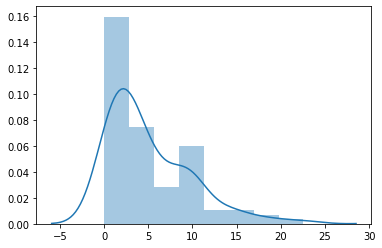

In [4]:
sns.distplot(betas)

In [5]:
def sal(par,y):
    assert len(par)>=4, "not enough params"
    return par[0]+par[1]*np.sinh(par[2]*np.arcsinh(y) + par[3])

In [6]:
d_sal = elementwise_grad(sal,1)

In [7]:
def sal_comp(par,y,n):
    assert len(par)>=4*n, "not enough params"
    comp = copy.deepcopy(y)
    for i in range(0,n):
        comp = sal(par[4*i:],comp)
    return comp

In [8]:
def d_sal_comp(par,y,n):
    assert len(par)>=4*n, "not enough params"
    comp = copy.deepcopy(y)
    d_comp = 1
    for i in range(0,n):
        d_comp *= d_sal(par[4*i:],comp)
        comp = sal(par[4*i:],comp)
    return d_comp

In [9]:
# http://stackoverflow.com/questions/45599524/partial-derivative-using-autograd

In [10]:
def cov_kernel(gamma,x):
    return np.exp(-gamma*(np.abs(x)))

In [11]:
par = np.random.rand(4*n)
phi_y = sal_comp(par,betas,n)
phi_y = phi_y[np.newaxis].reshape(-1,1)
t_phi_y = np.transpose(phi_y)

print(phi_y.shape,t_phi_y.shape)

(100, 1) (1, 100)


In [12]:
def nllf(par):
    phi_y = sal_comp(par,betas,n)
    phi_y = phi_y[np.newaxis].reshape(-1,1)
    t_phi_y = np.transpose(phi_y)
    
    cov_xx = cov_kernel(gamma,np.log(np.exp(phi_y) @ np.exp(-(t_phi_y))))
    gaussian_params = 0.5 * (t_phi_y) @ np.linalg.inv(cov_xx) @ phi_y
    
    chain_d_sal = d_sal_comp(par,betas,n)
    
    return  0.5 * np.log(np.linalg.det(cov_xx)) + gaussian_params - sum(np.log(chain_d_sal))

In [13]:
nllf(np.random.rand(4*n))

/home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


array([[-inf]])

In [14]:
res = minimize(nllf, np.random.rand(4*n), method='L-BFGS-B')
while res.success == False:
    try:
        res = minimize(nllf, np.random.rand(4*n), method='L-BFGS-B')
#         rand = np.random.uniform(low=-5, high=5, size=(4*n, 1))
#         res = minimize(nllf, rand , method='L-BFGS-B')
#         print(rand)
    except:
        pass

/home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in subtract
  df = (f(*((xk + d,) + args)) - f0) / d[k]
/home/chen/work/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/home/chen/work/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in matmul
  
/home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in sinh
  return f_raw(*args, **kwargs)
/home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
/home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_v

In [15]:
res

      fun: array([[-4.80540956]])
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.95283847e-05, -5.54223334e-05, -5.63730396e-02, -3.78577170e-03,
        0.00000000e+00,  1.57740487e-04, -2.15678142e-02, -1.87583282e-04,
       -4.26325641e-03, -1.12962084e-02, -2.18849902e+02, -3.62268793e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4771
      nit: 242
   status: 0
  success: True
        x: array([-1.15708616e+01,  1.44727398e+01,  3.32696827e+00,  7.63014850e+00,
       -1.19215766e+01,  1.31284126e+01,  1.05385434e+01,  4.11078047e+00,
       -3.95684835e+01,  3.27453134e+01,  1.03422481e-03,  8.31145494e-01])

In [16]:
res.x

array([-1.15708616e+01,  1.44727398e+01,  3.32696827e+00,  7.63014850e+00,
       -1.19215766e+01,  1.31284126e+01,  1.05385434e+01,  4.11078047e+00,
       -3.95684835e+01,  3.27453134e+01,  1.03422481e-03,  8.31145494e-01])

In [17]:
transformed_betas = sal_comp(res.x,betas,n)

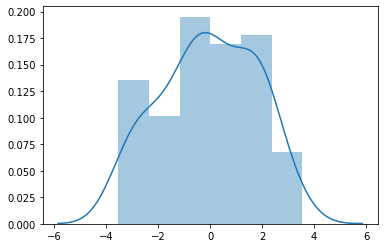

In [18]:
sns.distplot(transformed_betas)